Preparing our corpus


In [ ]:
!pip install wiki-dump-reader
!pip install sentencepiece
#Necessary imports
from wiki_dump_reader import Cleaner, iterate
import numpy as np
import re
import sentencepiece as spm
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
#Code adapted from https://github.com/CyberZHG/wiki-dump-reader
#We remove all english alphabets, numeric digits and symbols with the help of regex library and then dump the remaining in a single txt file
def write_corpus():
    corpus_file = 'Corpus.txt'
    page_count = 0
    cleaner = Cleaner()
    with open(corpus_file, 'w', encoding='utf-8') as output:
        for title, text in iterate('mrwiki-latest-pages-articles.xml'):
            text = cleaner.clean_text(text)
            cleaned_text, links = cleaner.build_links(text)
            # Define a regular expression pattern to match English words, symbols, and digits
            pattern = r'[a-zA-Z0-9!@#$%^&*()_+=\[\]{};:\'",<>/\\|~`-]+'
            # Use re.sub() to remove English words, symbols, and digits
            marathi_text = re.sub(pattern,"", cleaned_text)
            output.write(title + '\n' + marathi_text + '\n')
            page_count += 1
            if page_count % 100 == 0:
                print(f'Pages dumped = {page_count}', end='\r')
    print(page_count)
    output.close()
write_corpus()

160735


In [ ]:
with open('/Corpus.txt', 'r') as f:
    text = f.read()
print(len(text))
print(text[0:1000])
#Printing the first few lines to see the preprocessed text

104464511
औदुंबर (कविता)
॥ औदुंबर रसग्रहण ॥
एखाद्या कुशल चित्रकाराने कुंचल्याच्या अवघ्या चारसहा फटकाऱ्यांसरशी एखादे सुरेख चित्र निर्माण करावे तद्वत अवघ्या आठ ओळीत बालकवींनी एक सुंदर निसर्गचित्र शब्दांच्या कुंचल्याने या कवितेत रेखाटलेले आहे. हे चित्र रंगविताना कवीने विविध रंग वापरलेले आढळतील. निळासावळा झरा शेतमळ्यांची हिरवी गरदी पांढरी पायवाट व काळा डोहमोजक्या रंगांनी शब्दांच्या चौकटीत बसविलेले हे एक साधे व जिवंत चित्र आहे. बालकवींची रंगदृष्टी येथे आपल्या प्रत्ययास येते.
पहिल्या चार ओळींत टेकड्या गाव शेतमळे व झरा यांनी व्यापलेले विहंगम दृश्य दिसते.
शेतमळ्यांच्या हिरव्या गरदीतून वाहणाऱ्या निळ्यासावळ्या झऱ्यावरून जी नजर मागे जाते ती चार घरांचे चिमुकले गाव ओलांडून पैल टेकडीपर्यंत पोचते. केवढा विस्तीर्ण पट कवीने पार्श्वभूमीसाठी घेतलेला आहे पुढील दोन ओळीत त्या काळ्या डोहाच्या लाटांवर गोड काळिमा पसरून जळात पाय टाकून बसलेला औदुंबर दाखविला आहे.
केवळ निसर्गाचे एक सुरम्य चित्र रंगविण्याचा कवीचा हेतू दिसत नाही. पहिल्या चार ओळींतील आनंदी व खेळकर वृत्तीच्या पार्श्वभूमीवर नैराश्याची छटा पसरविणारे काळ

In [ ]:
CHUNK_SIZE = 1000000
#This is where we train our SentencePiece model on our corpus
#We took vocab size to be 80000 after trying it out for various values between 10000 and 100000
spm.SentencePieceTrainer.Train(f'--input=/Corpus.txt --model_prefix=m --vocab_size=80000')
model = spm.SentencePieceProcessor(model_file='m.model')

vocab_counter = Counter()
tokens_cumulative = []
vocab_cumulative = []
total_tokens_count = 0

#This function tokenizes the chunk that we provide, using the SentencePiece model
def tokenize_chunk(chunk, model):
    return model.EncodeAsPieces(chunk)

#Here, instead of reading the entire txt file at once, we read it in chunks of size 100000 to avoid crashing
with open("/Corpus.txt", "r", encoding="utf-8") as f:
    while True:
        chunk = f.read(CHUNK_SIZE)
        if not chunk:
            break
        tokens = tokenize_chunk(chunk, model)
        vocab_counter.update(tokens)
        total_tokens_count += len(tokens)
        tokens_cumulative.append(total_tokens_count)
        vocab_cumulative.append(len(vocab_counter))

In [ ]:
#This function plots the rank of the words vs the frequency of the words for our vocabulary
#We use this to verify the Zipf's Law
def verify_zipfs_law(freq):
    sorted_freq = sorted(freq.values(), reverse=True)
    plt.loglog(sorted_freq)
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Zipf\'s Law Verification')
    plt.show()

#This function plots the Vocabulary size vs the total number of tokens
#We also plot a line depicting the expected behaviour of the graph using the formula 'expected_vocab_size = K * x_values ** beta'
#where the values of K and beta are found by fitting log(vocab count) and log(token count) to a degree 1 polynomial
def verify_heaps_law(tokens_cumulative, vocab_cumulative):
    x= np.log(tokens_cumulative)
    y = np.log(vocab_cumulative)
    coefficients = np.polyfit(x, y, 1)
    beta = coefficients[0]
    K = np.exp(coefficients[1])
    # Creating an array of values for the expected line
    x_values = np.array(tokens_cumulative)
    expected_vocab_size = K * x_values ** beta
    plt.plot(tokens_cumulative, vocab_cumulative, label='Data')
    plt.plot(x_values, expected_vocab_size, 'r--', label=f'Expected (K={K:.2f}, beta={beta:.2f})')
    plt.xlabel('Total Tokens')
    plt.ylabel('Vocabulary Size')
    plt.title('Heap\'s Law Analysis')
    plt.legend()
    plt.show()


In [ ]:
print("Total tokens count=", total_tokens_count)
print("Types of Vocabulary count:", len(vocab_counter))
# Sorting the vocabulary by frequency in descending order
sorted_vocab = sorted(vocab_counter.items(), key=lambda item: item[1], reverse=True)
print("Top 10 Ranked Words:")
for i, (word, freq) in enumerate(sorted_vocab[:10], 1):
    print(f"{i}. {word}: {freq}")

Total tokens count= 19245043
Types of Vocabulary count: 86931
Top 10 Ranked Words:
1. .: 1319145
2. ▁आणि: 236879
3. ▁आहे: 235772
4. ▁या: 140653
5. ▁हे: 136310
6. च्या: 136278
7. ▁व: 119205
8. ी: 96989
9. स: 96887
10. ▁एक: 96296


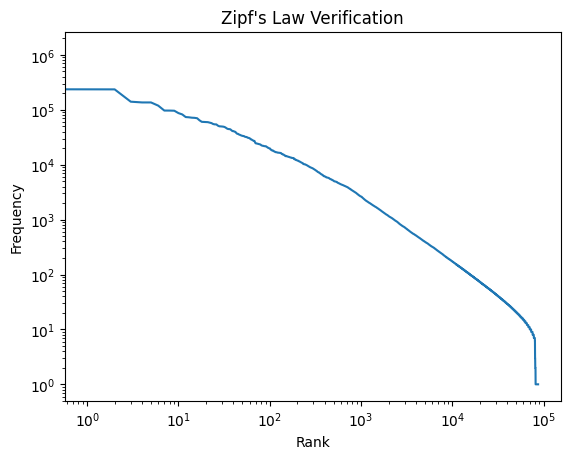

In [ ]:
verify_zipfs_law(vocab_counter)

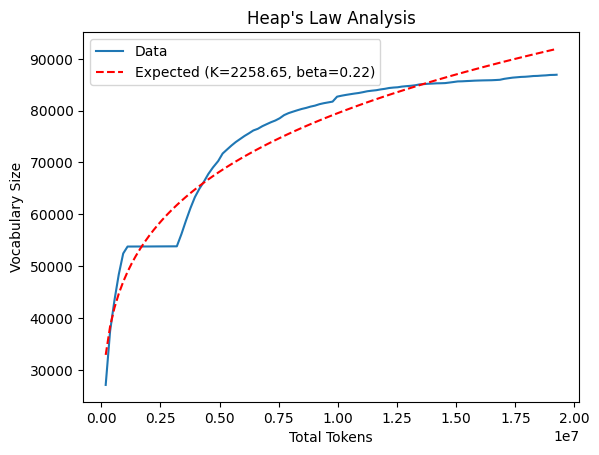

In [ ]:
verify_heaps_law(tokens_cumulative, vocab_cumulative)

Zipf's law basically states that as the number of words in a document increases, the rate of the count of distinct words available in the document slows down. Our real data follows this law pretty well. The vocabulary size increases with a much faster rate w.r.t the total tokens in the beginning and later slows down. Clearly, we can observe flattening of the curve as the number of tokens (and number of articles read) increases.